In [1]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [2]:
train_data = pl.read_csv("train_data.csv")
test_data = pl.read_csv("test_data.csv")
train_data.shape,test_data.shape

((4907, 19), (2108, 19))

In [3]:
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

In [4]:
calculate_vif(train_data,"Churn")

,variables,VIF
0,const,88.302993
8,MonthlyCharges,12.026859
9,TotalCharges,9.991192
5,InternetService,8.294991
4,tenure,7.119423


No high multicollinear features

In [14]:
train_data=train_data.drop("MonthlyCharges")
test_data=test_data.drop("MonthlyCharges")

imbalance ratio inverse

In [15]:
ratio=len(train_data.filter(train_data["Churn"]==1))/(len(train_data))
ratio

0.2649276543713063

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder

cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

transformer = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
        ("scaler", StandardScaler(), num_cols)
     ],
    remainder="passthrough",
)

pipe = Pipeline(
    [
        ("tranformer", transformer),
        ("classifier", LogisticRegression(class_weight={0:1,1:ratio*10})),
    ]
)
pipe

Pipeline(steps=[('tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['MultipleLines',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'PaymentMethod']),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents', 'tenure',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'TotalCharges'])])),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 2.6492765437130625}))])

In [17]:
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=10,random_state=42)

cv_results = cross_validate(pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Standard Deviation of Train roc auc Scores: {cv_results["train_roc_auc"].std()}')
print(f'Mean Train recall Score: {cv_results["train_recall"].mean()}')
print(f'Standard Deviation of Train recall Scores: {cv_results["train_recall"].std()}\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Standard Deviation of Test roc auc Scores: {cv_results["test_roc_auc"].std()}')
print(f'Mean Test recall Score: {cv_results["test_recall"].mean()}')
print(f'Standard Deviation of Test recall Scores: {cv_results["test_recall"].std()}')

Mean Train roc auc Score: 0.8428212220711899
Standard Deviation of Train roc auc Scores: 0.0018715991872484223
Mean Train recall Score: 0.7944358974358973
Standard Deviation of Train recall Scores: 0.0035312594445417395

Mean Test roc auc Score: 0.8395223687170017
Standard Deviation of Test roc auc Scores: 0.01715854712001033
Mean Test recall Score: 0.7913076923076923
Standard Deviation of Test recall Scores: 0.03257499313146194


In [18]:
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score
from sklearn.model_selection import cross_val_predict
predictions= cross_val_predict(pipe,X_test,y_test)
print("logistic regression accuracy :",accuracy_score(y_true=y_test,y_pred=predictions))
print("auc roc",roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))

logistic regression accuracy : 0.7523719165085389
auc roc 0.7567437246216316
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1548
           1       0.52      0.77      0.62       560

    accuracy                           0.75      2108
   macro avg       0.71      0.76      0.72      2108
weighted avg       0.80      0.75      0.76      2108



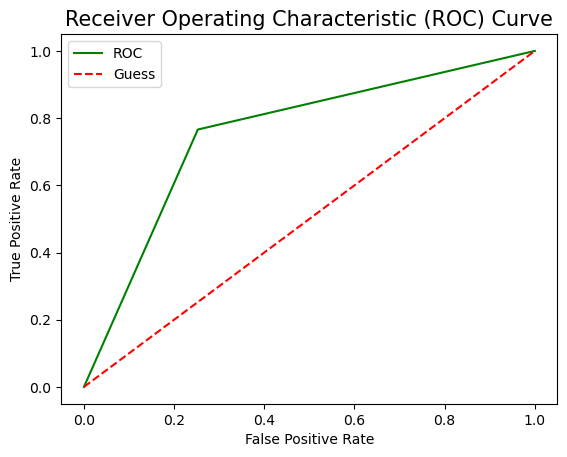

In [19]:
fpr, tpr, thresholds=roc_curve(y_test,predictions)
plot_roc_curve(fpr, tpr)

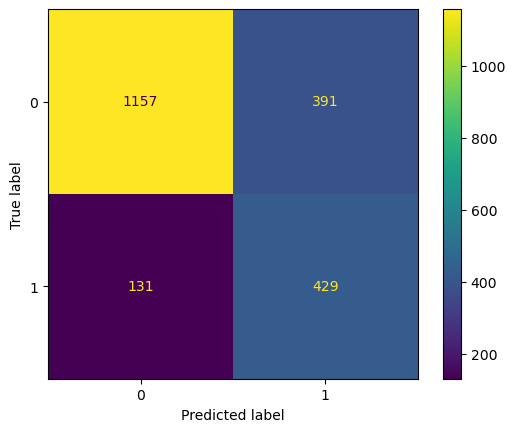

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,predictions))
fig.plot()

In [21]:
from sklearn.metrics import roc_auc_score,f1_score,precision_score,accuracy_score,recall_score,matthews_corrcoef
# Evaluation
roc_auc = roc_auc_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test,predictions)
precision = precision_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"ROC AUC: {roc_auc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"precision : {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Corr : {coef}")

ROC AUC: 0.76
F1 Score: 0.62
Recall score: 0.77
precision : 0.52
Accuracy: 0.75
Corr : 0.46520509969596374


In [22]:
roc_auc,f1,recall,coef

(0.7567437246216316,
 0.6217391304347827,
 0.7660714285714286,
 0.46520509969596374)

80% of churners are identified with 63% precision (chance that our predicted churners are actually churners)